In [238]:
!pwd

/global/cscratch1/sd/huikong/wtheta_cal/mock_corr/nbody_kit/notebook


In [174]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import healpy as hp

In [175]:
import astropy.io.fits as fits
dat = fits.getdata('/global/cscratch1/sd/ajross/tarcat/vtest/tv0.49.0/LRGtargetsDR9v0.49.0_masked.fits')
random = fits.getdata('/global/cscratch1/sd/ajross/tarcat/vtest/tv0.49.0/randomsDR9v0.49.0_0_masked.fits')

In [176]:
set(dat['PHOTSYS'])

{'N', 'S'}

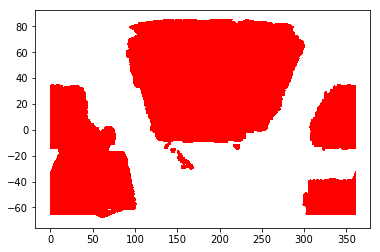

In [177]:
plt.plot(dat['ra'],dat['dec'],'r,')

In [178]:
pixfn      = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.50.0/pixweight/main/resolve/dark/pixweight-1-dark.fits'
hdr        = fits.getheader(pixfn,1)
fsys_all   = fits.getdata(pixfn)

In [179]:
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(nside,nest)

256 True


In [180]:
ra,dec = dat['ra'],dat['dec']
pts = hp.pixelfunc.ang2pix(nside,ra,dec,nest = nest,lonlat = True)

In [181]:
npo = 12*nside**2
pixlg = np.zeros(npo)
ng=0.
for i in range(0,len(dat)):
        pixlg[pts[i]] += 1.
        ng+=1.

In [182]:
ra,dec = random['ra'],random['dec']
pts_ran = hp.pixelfunc.ang2pix(nside,ra,dec,nest = nest,lonlat = True)

In [184]:
npo = 12*nside**2
pixlr = np.zeros(npo)
nr=0.
for i in range(0,len(random)):
        pixlr[pts_ran[i]] += 1.
        nr+=1.

In [185]:
fsys = fsys_all['STARDENS']

(array([  67198.,  202302.,   98668.,   62027.,   45574.,   38376.,
          30777.,   24732.,   20387.,   17766.]),
 array([   19.06365013,   415.58755856,   812.11146698,  1208.6353754 ,
         1605.15928383,  2001.68319225,  2398.20710068,  2794.7310091 ,
         3191.25491753,  3587.77882595,  3984.30273438]),
 <a list of 10 Patch objects>)

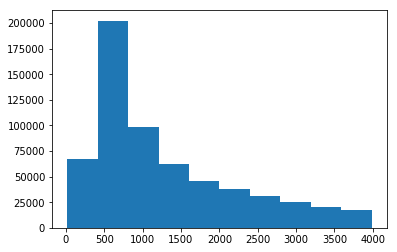

In [186]:
sel = (fsys>0)&(fsys<4000)
plt.hist(fsys[sel])

In [187]:
sysmin=0
sysmax=4000

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import healpy as hp
import astropy.io.fits as fits

class source(object):
    def __init__(self,source_type,region):
        topdir = '/global/cscratch1/sd/ajross/tarcat/vtest/tv0.49.0/'
        if source_type=='ELG':
            dat = fits.getdata(topdir+'ELGtargetsDR9v0.49.0_masked.fits')
            random = fits.getdata(topdir+'randomsDR9v0.49.0_0_masked.fits')
        elif source_type=='LRG':
            dat = fits.getdata(topdir+'LRGtargetsDR9v0.49.0_masked.fits')
            random = fits.getdata(topdir+'randomsDR9v0.49.0_0_masked.fits')
        if region == 'BassMzls':
            sel_dat = (dat['PHOTSYS']=='N')
            sel_ran = (random['PHOTSYS']=='N')
        elif region == 'DS':
            sel_dat = self.sel_reg(dat['ra'],dat['dec'],'DS')
            sel_ran = self.sel_reg(random['ra'],random['dec'],'DS')
        elif region == 'DN':
            sel_dat = self.sel_reg(dat['ra'],dat['dec'],'DN')
            sel_ran = self.sel_reg(random['ra'],random['dec'],'DN')
        elif region == 'all':
            sel_dat = np.ones(len(dat),dtype=np.bool)
            sel_ran = np.ones(len(random),dtype=np.bool)
        self.data = dat[sel_dat]
        self.random = random[sel_ran]
    def sel_reg(self,ra,dec,reg):
       wra = (ra > 100-dec)
       wra &= (ra < 280 +dec)
       if reg == 'DN':
          w = dec < 32.375
          w &= wra
       if reg == 'DS':
          w = ~wra
          w &= dec > -25
       return w

def systematics(source_type,region,sys_name,sysmax,sysmin):
    my_source = source(source_type,region)
    pixfn      = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.50.0/pixweight/main/resolve/dark/pixweight-1-dark.fits'
    hdr        = fits.getheader(pixfn,1)
    fsys_all   = fits.getdata(pixfn)
    nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
    dat = my_source.data
    random = my_source.random
    ra,dec = dat['ra'],dat['dec']
    pts = hp.pixelfunc.ang2pix(nside,ra,dec,nest = nest,lonlat = True)
    npo = 12*nside**2
    pixlg = np.zeros(npo)
    ng=0.
    for i in range(0,len(dat)):
        pixlg[pts[i]] += 1.
        ng+=1.
    ra,dec = random['ra'],random['dec']
    pts_ran = hp.pixelfunc.ang2pix(nside,ra,dec,nest = nest,lonlat = True)
    npo = 12*nside**2
    pixlr = np.zeros(npo)
    nr=0.
    for i in range(0,len(random)):
        pixlr[pts_ran[i]] += 1.
        nr+=1.
    fsys = fsys_all[sys_name]
    sel = (fsys>sysmin)&(fsys<sysmax)
    #total bins
    nsysbin = 10
    bing = np.zeros(nsysbin)
    binr = np.zeros(nsysbin)

    bintg = 0#total galaxies in good pixel
    bintr = 0#total random in good pixel
    obing = 0#total galaxies outside bin
    obinr = 0#total randoms outside bin
    ng0 = 0#total galaxies in bad pixel
    nr0 = 0#total random in bad pixel
    sysm = float(nsysbin)/(sysmax-sysmin)
    
    
    
    for i in range(0,npo):
        sysv = float(fsys[i])
        if sysv > 0: #the maps are not perfect, entries with 0s shouldn't be used
            bintg += pixlg[i]
            bintr += pixlr[i]
            bins = int((sysv-sysmin)*sysm)
            if bins >= 0 and bins < nsysbin:
                bing[bins] += pixlg[i]
                binr[bins] += pixlr[i]
            else:
                obing += pixlg[i]
                obinr += pixlr[i]
        else:
            nr0 += pixlr[i] #count numbers inside bad pixels in sys map
            ng0 += pixlg[i]

    print('total number of randoms/objects '+str(bintr)+'/'+str(bintg))
    print('number of randoms/objects where sys = 0 '+str(nr0)+'/'+str(ng0))
    print('number of randoms/objects outside tested range '+str(obinr)+'/'+str(obing))
    ave = float(bintg)/float(bintr)
    print('average number of objects per random is '+ str(ave))

    ns=np.zeros(nsysbin)
    nse=np.zeros(nsysbin)
    x = np.zeros(nsysbin)
    for i in range(0,nsysbin):
        sysv = sysmin + 1./(2.*sysm) + i/sysm
        x[i]=sysv
        if binr[i] > 0:
            ns[i] = bing[i]/binr[i]/ave
            nse[i] = np.sqrt(bing[i]/(binr[i])**2./(ave)**2.+(bing[i]/ave)**2./(binr[i])**3.)
        else:
            ns[i] = 1.
            nse[i] = 1.
    chin = sum((ns-1.)**2./nse**2.)
    print('flat:'+str(chin))
    z = np.polyfit(x,ns,1,w=1./nse)
    b=z[1];m=z[0]
    print('b='+str(z[1])+' m='+str(z[0]))
    chilin = sum((ns-(m*x+b))**2./nse**2.)
    print('slope:'+str(chilin))

    plt.errorbar(x,ns,nse,fmt='ko')
    ol = np.ones((len(x)))
    plt.plot(x,ol,'k:')
    plt.plot(x,m*x+b,'k--')

    plt.text(min(x)+0.1*(max(x)-min(x)),1.04,r'$\chi^2$ null ='+str(chin)[:5],color='k')
    plt.text(min(x)+0.1*(max(x)-min(x)),1.03,r'$\chi^2$ lin ='+str(chilin)[:5],color='k')
    plt.title(source_type+' '+region)
    plt.xlabel(sys_name)
    plt.savefig("%s_%s_%s_%.2f_%.2f.png"%(source_type,region,sys_name,sysmax,sysmin))




total number of randoms/objects 45817186.0/10880083.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 34062.0/8558.0
average number of objects per random is 0.23746729011249185
flat:702.025883252
b=0.990034238255 m=1.15191002853e-05
slope:290.528936697


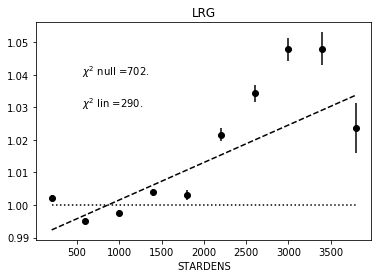

In [211]:
systematics('LRG','all','STARDENS',4000,0)

total number of randoms/objects 45817186.0/10880083.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 156660.0/39669.0
average number of objects per random is 0.23746729011249185
flat:3279.12090317
b=0.975732860612 m=0.596250889309
[ 0.97365748  0.99743839  1.01238434  1.0236574   1.02309116  1.03045405
  1.04191278  1.04190651  1.06287275  1.05747865]
[ 0.98169537  0.99362039  1.00554541  1.01747042  1.02939544  1.04132046
  1.05324548  1.06517049  1.07709551  1.08902053]
[ 0.00064658  0.00056706  0.00077976  0.00113642  0.00157291  0.00214349
  0.00299059  0.00396366  0.00553612  0.00750324]
slope:421.281492828


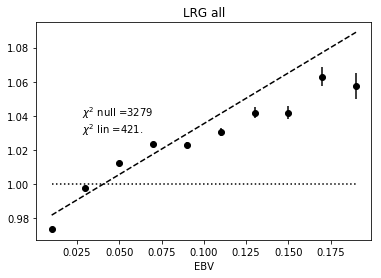

In [221]:
systematics('LRG','all','EBV',0.2,0)

total number of randoms/objects 11676420.0/2781707.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 14711.0/3600.0
average number of objects per random is 0.2382328658955399
flat:342.661839166
b=0.985530025875 m=1.58414802459e-05
[ 0.99648868  0.98937865  1.00440284  1.0137846   1.0213175   1.0240899
  1.02077973  1.03565756  1.03723471  1.00926302]
[ 0.98869832  0.99503491  1.00137151  1.0077081   1.01404469  1.02038128
  1.02671787  1.03305447  1.03939106  1.04572765]
[ 0.00165222  0.00099966  0.00159611  0.00227763  0.00304353  0.00369992
  0.00446423  0.0056114   0.00720761  0.01014651]
slope:86.6759586488


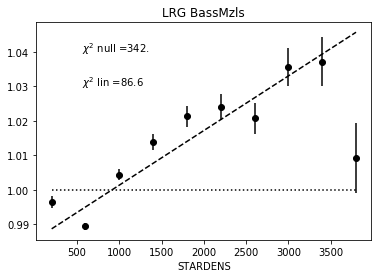

In [222]:
systematics('LRG','BassMzls','STARDENS',4000,0)

total number of randoms/objects 11676420.0/2781707.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 17647.0/4334.0
average number of objects per random is 0.2382328658955399
flat:472.128546408
b=0.990348709121 m=0.287138245543
[ 0.99049874  0.99395217  1.0232584   1.03402479  1.01014028  0.99723646
  1.00312543  0.98908683  1.01539659  1.09066027]
[ 0.99322009  0.99896286  1.00470562  1.01044839  1.01619115  1.02193392
  1.02767668  1.03341945  1.03916221  1.04490498]
[ 0.00098668  0.00129675  0.00180183  0.00268078  0.0037652   0.00463851
  0.0060143   0.00716918  0.01082651  0.0215366 ]
slope:301.071046048


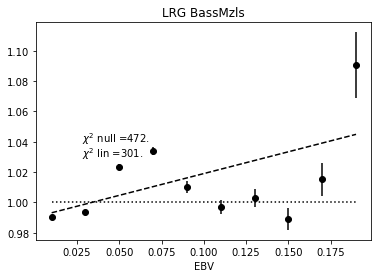

In [223]:
systematics('LRG','BassMzls','EBV',0.2,0)

total number of randoms/objects 12273175.0/2980227.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 6999.0/1671.0
average number of objects per random is 0.24282445251534343
flat:80.0535938408
b=1.00213487028 m=-2.53864160648e-06
slope:74.6449697569


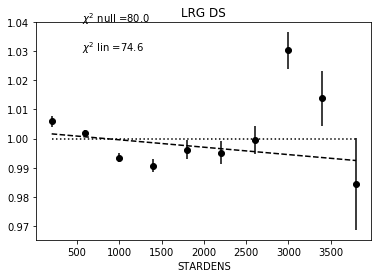

In [228]:
systematics('LRG','DS','STARDENS',4000,0)

total number of randoms/objects 13610333.0/3276284.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 12237.0/3244.0
average number of objects per random is 0.24072034093508218
flat:722.213785009
b=0.978962297052 m=2.41597725085e-05
slope:138.313199587


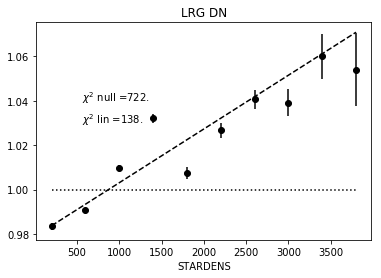

In [229]:
systematics('LRG','DN','STARDENS',4000,0)

total number of randoms/objects 12273175.0/2980227.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 130634.0/33263.0
average number of objects per random is 0.24282445251534343
flat:210.389371272
b=0.986720759433 m=0.215047645922
slope:86.1186474517


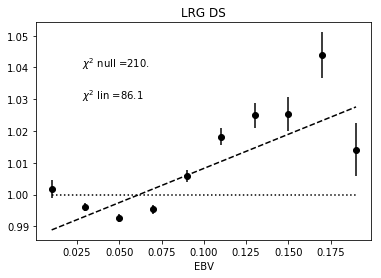

In [230]:
systematics('LRG','DS','EBV',0.2,0)

total number of randoms/objects 13610333.0/3276284.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 8379.0/2072.0
average number of objects per random is 0.24072034093508218
flat:816.794536551
b=0.972730335308 m=0.672336666971
slope:134.454730691


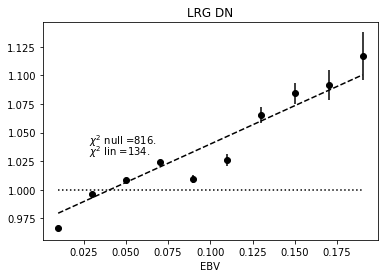

In [231]:
systematics('LRG','DN','EBV',0.2,0)

total number of randoms/objects 13610333.0/13000952.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 8379.0/6948.0
average number of objects per random is 0.9552265914434276
flat:3744.30953458
b=1.0289386702 m=-0.722196358799
slope:1582.85006043


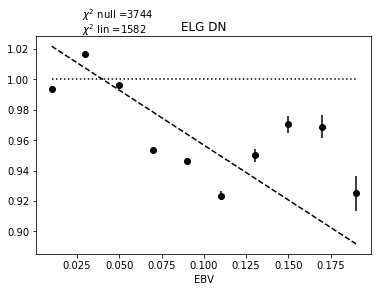

In [232]:
systematics('ELG','DN','EBV',0.2,0)

total number of randoms/objects 12273175.0/11905459.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 130634.0/196309.0
average number of objects per random is 0.9700390485754501
flat:14175.2824019
b=0.93938358736 m=0.885843337551
slope:8857.82489572


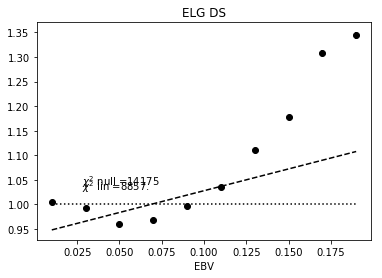

In [236]:
systematics('ELG','DS','EBV',0.2,0)

total number of randoms/objects 11676420.0/11845355.0
number of randoms/objects where sys = 0 0.0/0.0
number of randoms/objects outside tested range 17647.0/13488.0
average number of objects per random is 1.0144680475693748
flat:9624.58853623
b=1.04030657423 m=-1.21900641437
slope:627.697580416


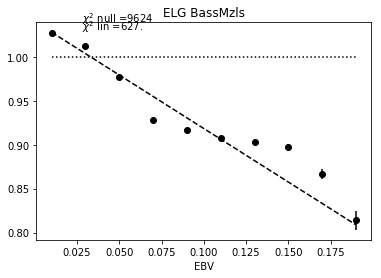

In [234]:
systematics('ELG','BassMzls','EBV',0.2,0)